In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import os
import shutil
import random

import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

In [26]:
data_dir = 'backup_data/dataset-resized'

categories = ["BATTERY", "BIOLOGICAL", "CLOTHES","CARDBOARD", "GLASS", "METAL", "PAPER", "PLASTIC", "NON_RECYCLE", "SHOES"]

In [27]:
#buat listing nama variable
filepaths = []
labels = []
classlist = os.listdir(data_dir)
for kelass in classlist:
    classpath = os.path.join(data_dir, kelass)
    if os.path.isdir(classpath):
        flist = os.listdir(classpath)
        for f in flist:
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(kelass)

In [28]:
# buat dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
print(df.head())
print(df['labels'].value_counts())

                                           filepaths   labels
0   backup_data/dataset-resized\battery\battery1.jpg  battery
1  backup_data/dataset-resized\battery\battery10.jpg  battery
2  backup_data/dataset-resized\battery\battery100...  battery
3  backup_data/dataset-resized\battery\battery101...  battery
4  backup_data/dataset-resized\battery\battery102...  battery
labels
shoes          1977
glass          1905
clothes        1865
paper          1644
plastic        1347
cardboard      1294
metal          1179
biological      985
battery         945
non_recycle     834
Name: count, dtype: int64


In [29]:
# Splitting data into train, validation, and test sets
train_split = .8
test_split = .1
dummy_split = test_split / (1 - train_split)
train_df, dummy_df = train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df = train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print('train_df length:', len(train_df), 'test_df length:', len(test_df), 'valid_df length:', len(valid_df))


train_df length: 11180 test_df length: 1397 valid_df length: 1398


In [30]:
# Preprocessing dataset
height = 224
width = 224
channels = 3
batch_size = 64
img_shape = (height, width, channels)
img_size = (height, width)

length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1, length+1) if length % n == 0 and length/n <= 80], reverse=True)[0]
test_steps = int(length/test_batch_size)
print('test batch size:', test_batch_size, 'test steps:', test_steps)

test batch size: 11 test steps: 127


In [31]:
#augmentation
gen = ImageDataGenerator(rescale=1./255, rotation_range=15, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
classes = list(train_gen.class_indices.keys())
print(classes)
class_count = len(classes)

Found 11180 validated image filenames belonging to 10 classes.
Found 1398 validated image filenames belonging to 10 classes.
Found 1397 validated image filenames belonging to 10 classes.
['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'non_recycle', 'paper', 'plastic', 'shoes']


In [32]:
# Image augmentation
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [33]:
#buat generator untuk train, valid, test
train_gen = gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                    target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
validgen = ImageDataGenerator(rescale=1./255)
valid_gen = validgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                         target_size=img_size, class_mode='categorical',
                                         color_mode='rgb', shuffle=True, batch_size=batch_size)
testgen = ImageDataGenerator(rescale=1./255)
test_gen = testgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                       target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 11180 validated image filenames belonging to 10 classes.
Found 1398 validated image filenames belonging to 10 classes.
Found 1397 validated image filenames belonging to 10 classes.


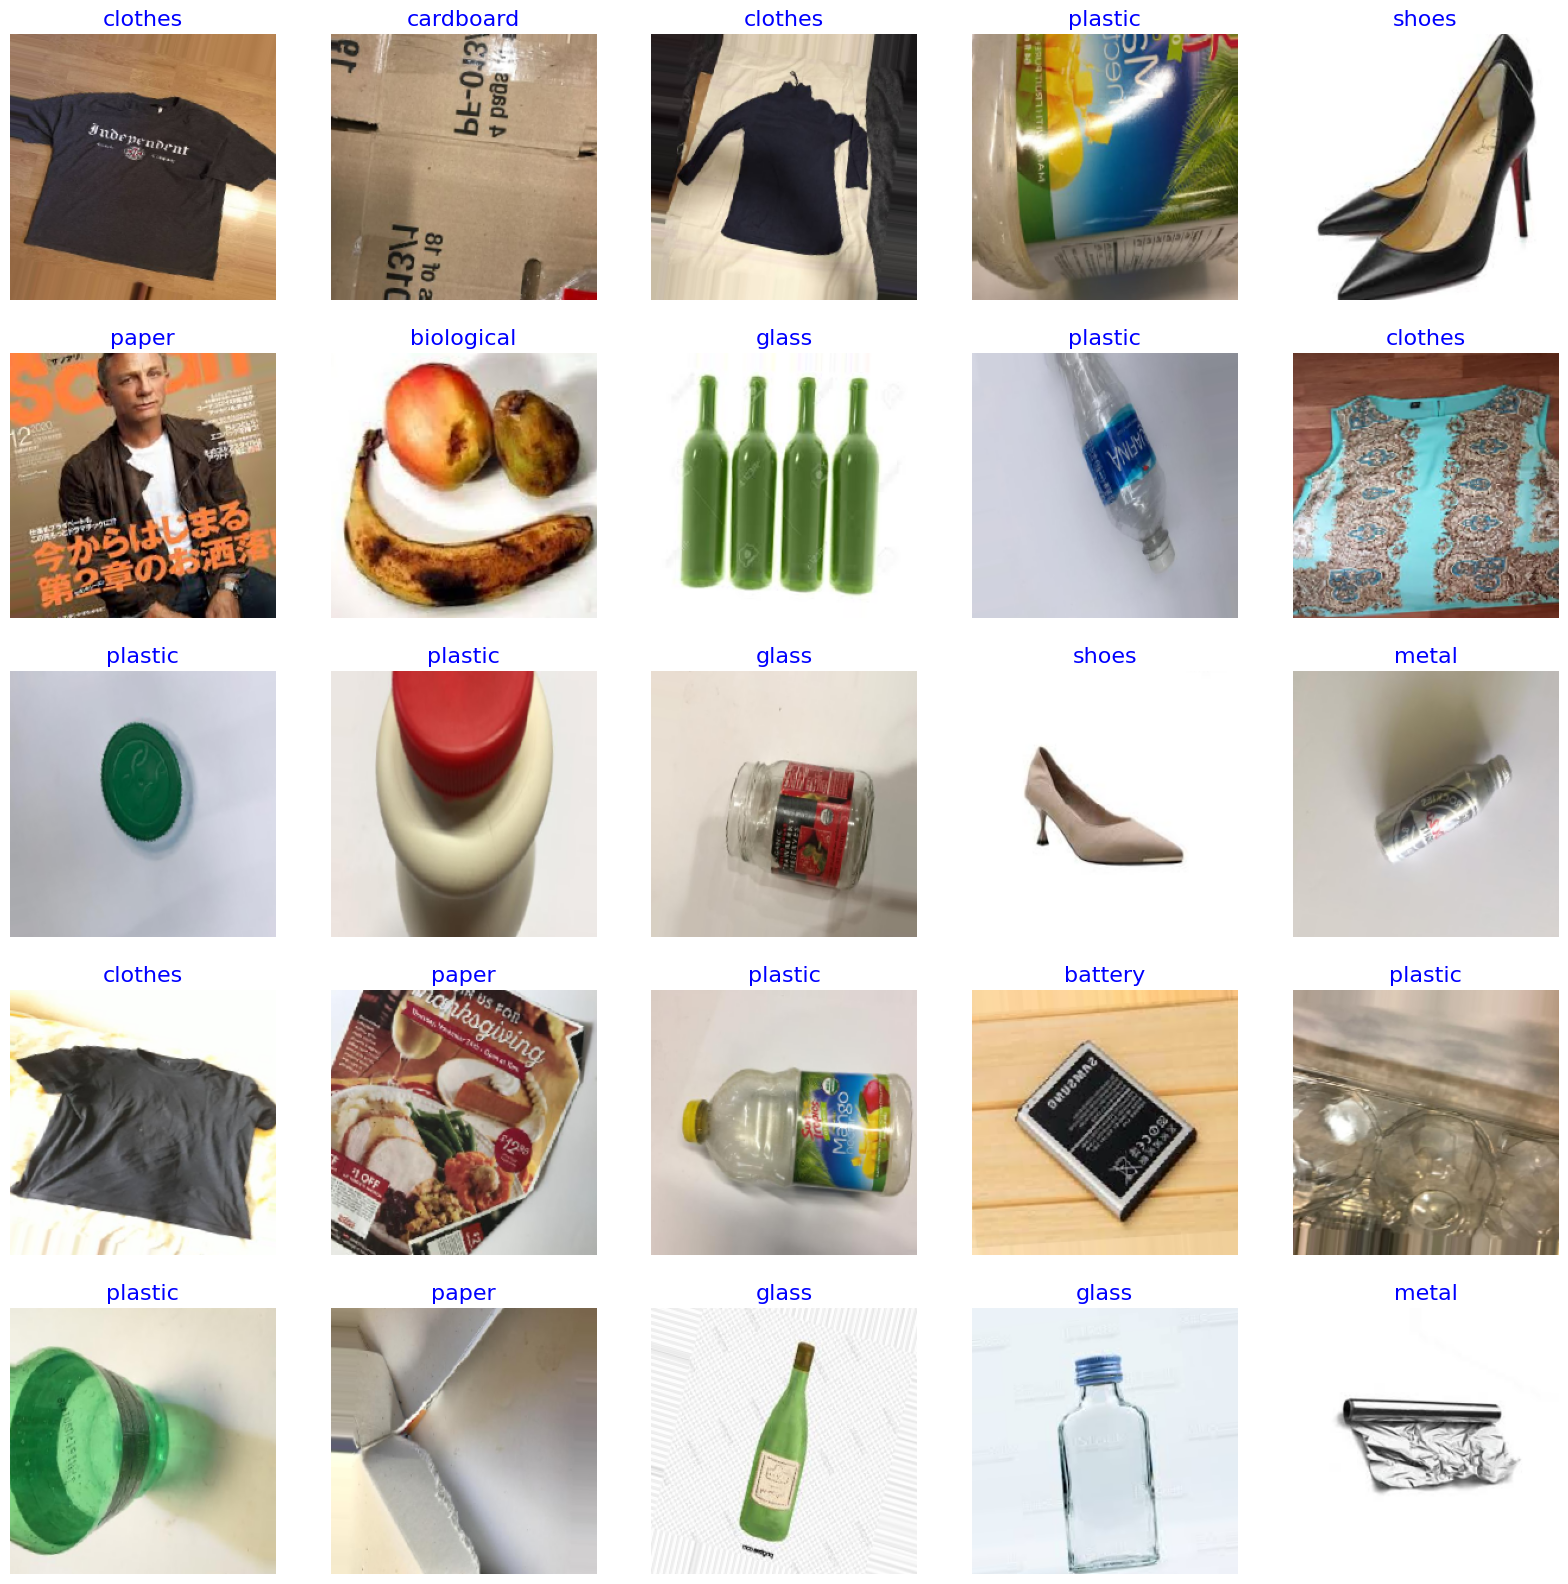

In [34]:
# Visualizing some sample images
def show_image_samples(gen):
    images, labels = next(gen)
    plt.figure(figsize=(20, 20))
    for i in range(min(len(labels), 25)):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i])
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

show_image_samples(train_gen)

In [35]:
# Definisiin extractor dan compile model
base_model = MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
base_model.trainable = False
extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block_15_project_BN').output)

# Build the model
model = Sequential([
    extractor,  # Feature extractor
    Conv2D(filters=32, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Conv2D(filters=64, padding='same', kernel_size=3, activation='relu'),
    MaxPooling2D(pool_size=2, strides=2),
    Dropout(rate=0.5),
    Flatten(),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Call build() method to build the model
model.build((None, 224, 224, 3))

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)       │ (None, 7, 7, 160)      │     1,364,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 32)       │        46,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,430,122 (5.46 MB)

 Trainable params: 65,258 (254.91 KB)

 Non-trainable params: 1,364,864 (5.21 MB)

In [36]:
# Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

history = model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=[early_stopping, checkpoint])

Epoch 1/20


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 550s 3s/step - accuracy: 0.3853 - loss: 2.1469 - val_accuracy: 0.7475 - val_loss: 0.7610
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/step - accuracy: 0.6923 - loss: 0.9129 - val_accuracy: 0.8026 - val_loss: 0.5808
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.7556 - loss: 0.7355 - val_accuracy: 0.8276 - val_loss: 0.5262
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 459s 3s/step - accuracy: 0.7868 - loss: 0.6409 - val_accuracy: 0.8484 - val_loss: 0.4857
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 420s 2s/step - accuracy: 0.8131 - loss: 0.5670 - val_accuracy: 0.8398 - val_loss: 0.5106
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.8275 - loss: 0.5248 - val_accuracy: 0.8369 - val_loss: 0.4903
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 595s 3s/step - accuracy: 0.8354 - loss: 0.5045 - val_accuracy: 0.8484 - val_loss: 0.4658
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.8506 - loss: 0.4743 - val_accuracy: 0.864

In [2]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss', color='blue', linestyle='-')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy', color='green', linestyle='-')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linestyle='--')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'plt' is not defined

In [ ]:
# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

    tf.saved_model.save(model, 'saved_model')

In [ ]:
# Load the trained model
model = tf.keras.models.load_model('saved_model')

# Define the classes
classes = ["BATTERY", "BIOLOGICAL", "CLOTHES", "CARDBOARD", "GLASS", "METAL", "PAPER", "PLASTIC", "NON_RECYCLE", "SHOES"]


In [ ]:
# Function to preprocess the image
def preprocess_image(img, img_size=(224, 224)):
    img = img.resize(img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch
    img_array = img_array / 255.0  # Rescale image
    return img_array

In [ ]:
# Function to predict the class of the image
def predict_image_class(model, img):
    img_array = preprocess_image(img)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    class_name = classes[predicted_class[0]]
    confidence = np.max(predictions) * 100
    return class_name, confidence

In [ ]:
# Function to display the image with predicted class and confidence
def display_prediction(img, class_name, confidence):
    plt.imshow(img)
    plt.title(f"Predicted: {class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

In [ ]:
# Create a file upload widget
upload_widget = widgets.FileUpload(accept='image/*', multiple=False)

def on_upload_change(change):
    # Get the uploaded file
    file = next(iter(upload_widget.value.values()))
    content = file['content']
    
    # Open the image
    img = Image.open(io.BytesIO(content))
    
    # Predict the class of the image
    class_name, confidence = predict_image_class(model, img)
    
    # Display the image and prediction
    display_prediction(img, class_name, confidence)

In [ ]:
# Observe the upload widget for changes
upload_widget.observe(on_upload_change, names='value')

# Display the upload widget
display(upload_widget)